In [1]:
%matplotlib inline

# Find the best cut on validation

When the `palladio` experiments are over, use the validation set to define the best cut. Then save the best model trained on the full training + validation set.

## `import` stuff

In [2]:
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from adenine.utils.extensions import Imputer
from sklearn.preprocessing import MinMaxScaler

# Predictive models
from palladio.wrappers import ElasticNetClassifier
from parsimony_sklearn import L1L2GLClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# GL stuff
import parsimony.functions.nesterov.gl as gl
import parsimony.algorithms as algorithms

mpi4py module not found. Adenine cannot run on multiple machines.
mpi4py module not found. PALLADIO cannot run on multiple machines.


## Load training & validation data

In [3]:
data_tr = pd.read_csv('../dataset_03-2017/data_training.csv', header=0, index_col=0)
labels_tr = pd.read_csv('../dataset_03-2017/labels_training.csv', header=0, index_col=0)
print('TR', data_tr.shape)

data_vld = pd.read_csv('../dataset_03-2017/data_validation.csv', header=0, index_col=0)
labels_vld = pd.read_csv('../dataset_03-2017/labels_validation.csv', header=0, index_col=0)
print('VLD', data_vld.shape)

# Group questionnaires together
variables = data_tr.columns
# Get the first 3 letters: this will be the group ID
heads = np.array([v[:3] for v in variables])
# Group variables according the first letters of their name
groups = [(np.where(heads == tag)[0]).tolist() for tag in np.unique(heads)]
A = gl.linear_operator_from_groups(len(variables), groups)

# Make the 'SP' as the positive class
labels_tr = np.where(labels_tr.values.ravel() == 'SP', 1, -1)
labels_vld = np.where(labels_vld.values.ravel() == 'SP', 1, -1)

('TR', (1853, 165))
('VLD', (398, 165))


## Choose model

Select the model among:
1. Elastic-Net
2. Logistic Regression
3. Group Lasso
4. Support Vector Machines
5. Random Forests
6. Gradient Boosting

In [4]:
models = {
          'ENET': {'model': ElasticNetClassifier(),
                   'params': {'classification__l1_ratio': np.linspace(0, 1, 10),
                              'classification__alpha': np.logspace(-5, 1, 10)}},
    
          'LR': {'model': LogisticRegression(),
                   'params': {'classification__penalty': ['l1'],
                              'classification__C': np.logspace(-5, 1, 10)}},
    
         # 'GL0': {'model': L1L2GLClassifier(),
         #        'params': {'classification__l2': [0.0],
         #                   'classification__l1': np.logspace(-5, 1, 10),
         #                   'classification__gl': np.logspace(-5, 1, 10),
         #                   'classification__A': [A],
         #                   'classification__algorithm': [algorithms.proximal.FISTA()],
         #                   'classification__algorithm_params': [dict(max_iter=5000)]}},
    
          'SVM': {'model': SVC(),
                  'params': {'classification__kernel': ['linear'],
                             'classification__C': np.logspace(-3, 3, 10),
                             'classification__gamma': np.logspace(-5, 1, 10)}},
    
          'RF': {'model': RandomForestClassifier(),
                 'params': {'classification__max_features': [None, 'log2', 'sqrt', 0.5],
                            'classification__min_samples_leaf': map(int, np.linspace(5, 100, 10)),
                            'classification__oob_score': [True],
                            'classification__n_estimators': [1000]}},
    
          'GB': {'model': GradientBoostingClassifier(),
                 'params': {'classification__max_depth': map(int, np.linspace(50, 100, 10)),
                            'classification__max_features': [None, 'log2', 'sqrt', 0.5],
                            'classification__n_estimators': map(int, np.linspace(10, 200, 10)),
                            'classification__learning_rate': [0.05]}}
         }

## Build the pipeline

Define two utilities function to build the pipeline and its CV version.

In [5]:
def build_pipeline(selected_model):
    """Build the MUCMD17 pipeline with the selected model."""
    imp = Imputer(strategy='nn') # TODO: uncomment this and comment next
#     imp = Imputer(strategy='mean')
    pp = MinMaxScaler(feature_range=(0, 1))
    clf = models[selected_model]['model']
    pipe = Pipeline([('imputing', imp),
                     ('preproc', pp),
                     ('classification', clf)])
    return pipe

def build_pipelineCV(selected_model):
    """Build the MUCMD17 pipeline with the selected model with param tuning via CV."""
    pipe = build_pipeline(selected_model)
    return GridSearchCV(pipe, param_grid=models[selected_model]['params'],
                        scoring='accuracy', n_jobs=-1,
                        cv=3, error_score=-np.inf)

## Get the variable ranking

Load the variable ranking obtained from each model.

In [7]:
for model in models.keys():
    ranking = pd.read_csv(os.path.join('variable_rankings', model+'.txt'),
                          sep=' : ', index_col=0, header=None,
                          engine='python').dropna()
    models[model]['ranking'] = ranking

## Fit models with increasing size

Use the variable ranking to make dataset of increasing dimension. Fit the model and validate on the validation set. Hence find the best cut.

In [ ]:
#model = 'ENET'
#model = 'SVM'
#model = 'RF'
model = 'GB'
#model = 'LR'

for model in models:
    # Get the ranking
    ranking = models[model]['ranking']

    # Get the pipeline
    pipe_cv = build_pipelineCV(model)

    # First divide the variables in blocks according
    # to their selection frequency (exclude features selected 0 times)
    sel_thresholds = filter(lambda x: x>0, np.unique(ranking.values))

    # Iterate on the thresholds and create the reduced subset of features
    accuracies = []
    for thresh in sel_thresholds:
        idx = np.where(ranking.values >= thresh)[0]  # get the indexes of the variables selected more than thresh times
        var = ranking.iloc[idx].index.tolist()  # get the actual variables list
        X, y = data_tr[var].values, labels_tr  # make the smaller X and the the y

        tic = time.time()
        pipe_cv.fit(X, y)
        toc = time.time()

        y_pred = pipe_cv.predict(data_vld[var].values)
        acc = metrics.accuracy_score(labels_vld, y_pred)
        accuracies.append(acc)
        print('[Thresh {:2.0f}] accuracy on vld: {:2.3f}'.format(thresh, acc))

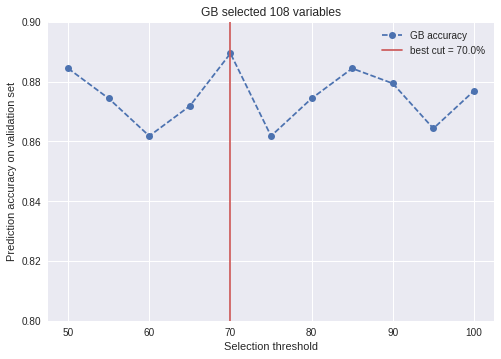

In [10]:
best_cut = sel_thresholds[np.where(accuracies == max(accuracies))[0][-1]]
best_cut_idx = np.where(ranking.values >= best_cut)[0]
selected_variables = ranking.iloc[best_cut_idx].index.tolist()

ranking.loc[selected_variables].to_csv(os.path.join('selected_variables', model+'_selected.csv'))

plt.plot(sel_thresholds, accuracies, '--o', label=model+' accuracy')
plt.axvline(best_cut, c='indianred', label='best cut = {}%'.format(best_cut))
plt.xlabel('Selection threshold')
plt.ylabel('Prediction accuracy on validation set')
plt.ylim([0.8, 0.9])
plt.legend()
plt.title(model+' selected {} variables'.format(len(selected_variables)))
plt.savefig(os.path.join('selected_variables', model+'_best_cut.png'));